<center>
    <h1>Reinforcement Project :</h1>
    <h1>Pac-Man Environment and Agent Benchmark </h1> 
</center>
    <p>
    <b>Coded By</b> Chloé Daems, Amir Mahmoudi and Anne-Claire Laisney</p>
    <p>
    <b>Github link :</b> https://github.com/chloedia/PacMan</p>


**Importation of the .py with the environment and the agents**

In [20]:
from Agents import *
from pacman_env_v2 import *
from scipy.stats import sem
import matplotlib.pyplot as plt

In [21]:
def moving_average(input_list, size = 1000):
    input_list = np.array(input_list)
    moving_means = []
    n = len(input_list)
    for i in range(size,n, size):
        mean = np.mean(input_list[max(0,i-size):i])
        moving_means.append(mean)
    return(moving_means)

**Methods to do the parameter sweeps**

In [3]:
def parameter_sweep(env_size,runs,ep):
    agents = {'Q_learning': QLearningAgent(), 'Sarsa' : SarsaAgent()}
    env = PacManEnv2(size=env_size)
    step_sizes = np.linspace(0.1,1.0,10)
    epsilon_value = 0.15
    epsilon_decay = 0.9 # every 20 episodes
    agent_info = {"num_actions": 5 , "epsilon": epsilon_value, "step_size": 0.5, "discount": 1.0, "seed": 0}
    env_info = {}
    num_runs = runs
    num_episodes = ep
    eps=0.1
    all_reward_sums = {}

    for algorithm in ["Q_learning", "Sarsa"]:
        print(f"start training {algorithm} \n")
        agent=agents[algorithm]
        for step_size in step_sizes:
            all_reward_sums[(algorithm, step_size)] = []
            agent_info["step_size"] = step_size
            for run in tqdm(range(num_runs)):
                agent_info["seed"] = run
                agents[algorithm].agent_init(agent_info)

                return_sum = 0
                for episode in range(num_episodes):
                    new_reward = run_episode(env,episode, agent, eps, epsilon_decay)
                    return_sum += new_reward[0]

                all_reward_sums[(algorithm, step_size)].append(return_sum/num_episodes)
                
    return all_reward_sums

In [4]:
def plot_step_size(dict_):
    step_sizes = np.linspace(0.1,1.0,10)
    for algorithm in ["Q_learning", "Sarsa"]:
        algorithm_means = np.array([np.mean(dict_[(algorithm, step_size)]) for step_size in step_sizes])
        algorithm_stds = np.array([sem(dict_[(algorithm, step_size)]) for step_size in step_sizes])
        plt.plot(step_sizes, algorithm_means, marker='o', linestyle='solid', label=algorithm)
        plt.fill_between(step_sizes, algorithm_means + algorithm_stds, algorithm_means - algorithm_stds, alpha=0.2)

    plt.legend()
    plt.xlabel("Step-size")
    plt.ylabel("Sum of\n rewards\n per episode",rotation=0, labelpad=50)
    plt.xticks(step_sizes)
    plt.show()

**Method to run an episode**

In [22]:
import time
def run_episode(env, episode, agent, epsilon_value, epsilon_decay, render = 0):
    current_reward = 0
    obs = env.reset()

    if render == 1 :
        env.world()

        env.writer.goto(160, 160)
        env.writer.dot(30,'black')
        env.writer.color('white')
        env.writer.write(env.total_reward)

    action = agent.agent_start(obs)
    ## decrease epsilon :
    if episode % 20 == 0:
        epsilon_value = epsilon_value*epsilon_decay
        agent.set_epsilon(epsilon_value)

    while True:
        obs, reward, done = env.step(action)
        current_reward += reward
        
        if render == 1:
            time.sleep(0.2)
            #clear_output(wait = True)
            env.render()
        elif render == 2:
            time.sleep(0.5)
            clear_output(wait = True)
            env.rendertext()

        if done:
            agent.agent_end(reward)
            #print(env.total_reward)
            break
        
        else:
            action = agent.agent_step(reward, obs)
    return current_reward, env.win

**Method to make the agent play**

In [23]:
#Lets see how many games it wins out of 100 episodes
def play(agent, n_games = 10, grid_size = 'small', viz = 0):
    '''
    viz (int) : {
        0 : No visualizing of the game
        1 : Viz on turtle (pop out window)
        2 : Text vizualisation on terminal
    }
    '''
    success = 0

    if viz == 1:
        setup(420, 420, 370, 0)
        hideturtle()
        tracer(False)
        
    env = PacManEnv2(grid_size)

    if(viz == 1):
        env.render_init()
        env.writer.goto(160, 160)
        env.writer.color('white')
        
    obs = env.reset()
    reward = 0
    #agent = agents_dict[agent_name]
    agent.set_epsilon(0)
    for i in tqdm(range(n_games)):
        reward, win = run_episode(env, i, agent, 0, 0, render = viz)
        if(win):
            success += 1
            
    env.close()
    return success / n_games


## Training of the models

**Initialize the main parameters**

In [24]:
###### main parameters
epsilon_value = 0.15
epsilon_decay = 0.9 # every 20 episodes
agent_info = {"num_actions": 5 , "epsilon": epsilon_value, "step_size": 0.5, "discount": 1.0, "seed": 0}

### Training on the small grid

In [38]:
#### play episode
from IPython.display import clear_output
def train(epsilon_value, viz = 0, grid_size = 'small'):
    '''
    viz (int) : {
        0 : No visualizing of the game
        1 : Viz on turtle (pop out window)
        2 : Text vizualisation on terminal
    }'''
    
    ##### initialise both agents
    agents_dict = {'Sarsa' : SarsaAgent(), 'Q_learning': QLearningAgent()}

    for agent_name in agents_dict.keys():
        agents_dict[agent_name].agent_init(agent_info)
    
    if viz == 1:
        setup(420, 420, 370, 0)
        hideturtle()
        tracer(False)
    
    env = PacManEnv2(size=grid_size)

    if(viz == 1):
        env.render_init()
        env.writer.goto(160, 160)
        env.writer.color('white')

    number_of_episodes = 10000
    rewards = {}

    for name, agent in agents_dict.items():
        print(f"start training {name}")
        rewards_dict = {}
        agent.set_epsilon(epsilon_value[name])
        for episode in tqdm(range(number_of_episodes), position = 0):
            new_reward = run_episode(env, episode, agent, epsilon_value[name], epsilon_decay, render = viz)
            rewards_dict[episode] = new_reward # if episodes terminates, save the obtained reward
                
        rewards[name] = rewards_dict

    return agents_dict, rewards

epsilon_value = {'Sarsa': 0.2, 'Q_learning':0.1}
small_agents_dict, small_rewards = train(epsilon_value, viz = 0, grid_size = 'small' )

start training Sarsa


100%|█████████████████████████████████████| 10000/10000 [03:12<00:00, 51.86it/s]


start training Q_learning


100%|█████████████████████████████████████| 10000/10000 [03:32<00:00, 47.05it/s]


#### Plotting of the sum of reward evolution during the episodes

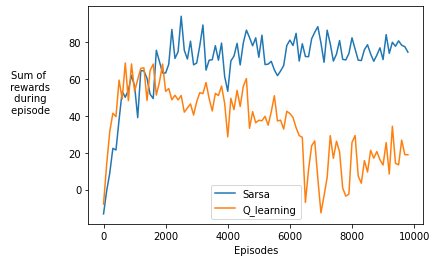

In [39]:
import matplotlib.pyplot as plt
size = 100
for name in small_rewards.keys():
    rewards_list = list(small_rewards[name].values())
    moving_means = moving_average(rewards_list, size = size)
    plt.plot([size*episode for episode in range(0,len(moving_means))],moving_means, label=name)
plt.xlabel("Episodes")
plt.ylabel("Sum of\n rewards\n during\n episode",rotation=0, labelpad=40)
plt.legend()
plt.show()

#### Comparing the step sizes

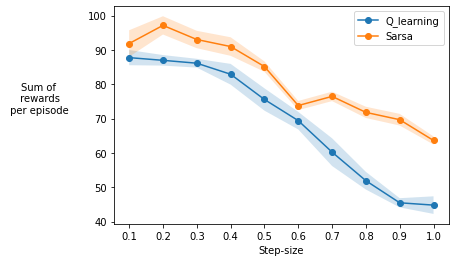

In [10]:
rewards_small=parameter_sweep('small',10,1000)
plot_step_size(rewards_small)

start training Q_learning 



100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.33it/s]


start training Sarsa 



100%|███████████████████████████████████████████| 10/10 [00:08<00:00,  1.22it/s]


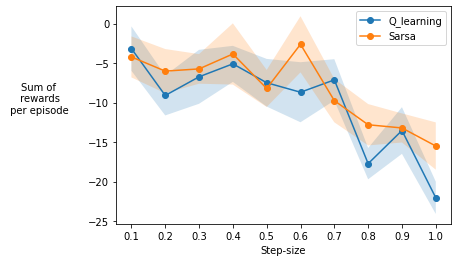

In [33]:
rewards_small=parameter_sweep('small',10,100)
plot_step_size(rewards_small)

#### Let the Agents Play
Let's see the winning rate of each agent on 1000 episodes.

In [15]:
for name in small_rewards.keys():
    winning_rate = play(small_agents_dict[name], 1000, grid_size='small', viz = 0)
    print(f"The winning rate of the {name} agent is {winning_rate * 100}% ")

100%|███████████████████████████████████████| 1000/1000 [00:29<00:00, 33.62it/s]


The winning rate of the Sarsa agent is 99.2% 


100%|███████████████████████████████████████| 1000/1000 [01:54<00:00,  8.73it/s]

The winning rate of the Q_learning agent is 89.0% 


The Sarsa Agent is better than the Q_learning one. Let's visualize how it plays.

#### Lets vizualize the game

In [28]:
#Let's see some games :
#viz = 2 for the viz with turtle  
winning_rate = play(agent = small_agents_dict['Sarsa'], n_games = 1, grid_size = 'small', viz = 2) 

100%|█████████████████████████████████████████████| 1/1 [00:20<00:00, 20.75s/it]

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 2 2 2 2 2 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 4 0 0 0 2 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 2 0 2 2 2 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 2 0 0 0 2 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 2 3 2 2 2 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 





![GifSmall](gif_smallGridSarsa.gif)

### Training on Medium Grid

In [40]:
epsilon_value = {'Sarsa': 0.4, 'Q_learning':0.1}
medium_agents_dict, medium_rewards = train(epsilon_value, viz = 0, grid_size = 'medium')

start training Sarsa


100%|█████████████████████████████████████| 10000/10000 [11:11<00:00, 14.89it/s]


start training Q_learning


100%|█████████████████████████████████████| 10000/10000 [16:00<00:00, 10.41it/s]


#### Plotting of the sum of reward evolution during the episodes

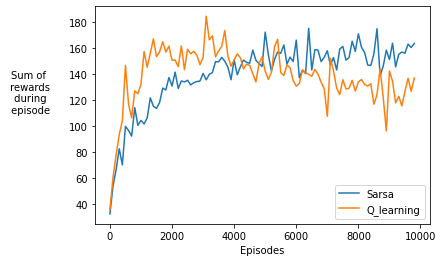

In [41]:
import matplotlib.pyplot as plt
size = 100
for name in small_rewards.keys():
    rewards_list = list(medium_rewards[name].values())
    moving_means = moving_average(rewards_list, size = size)
    plt.plot([size*episode for episode in range(0,len(moving_means))],moving_means, label=name)
plt.xlabel("Episodes")
plt.ylabel("Sum of\n rewards\n during\n episode",rotation=0, labelpad=40)
plt.legend()
plt.show()

#### Comparing the step sizes

start training Q_learning 



100%|███████████████████████████████████████████| 10/10 [00:45<00:00,  4.56s/it]


start training Sarsa 



100%|███████████████████████████████████████████| 10/10 [00:47<00:00,  4.71s/it]


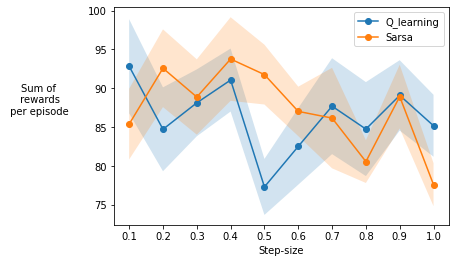

In [32]:
rewards_medium=parameter_sweep('medium',10,100)
plot_step_size(rewards_medium)

#### Let the Agents Play
Let's see the winning rate of each agent on 1000 episodes.

In [42]:
for name in medium_rewards.keys():
    winning_rate = play(agent = medium_agents_dict[name], n_games = 1000, grid_size='medium', viz = 0)
    print(f"The winning rate of the {name} agent is {winning_rate * 100}% ")

100%|███████████████████████████████████████| 1000/1000 [02:59<00:00,  5.56it/s]


The winning rate of the Sarsa agent is 14.799999999999999% 


100%|███████████████████████████████████████| 1000/1000 [05:16<00:00,  3.16it/s]

The winning rate of the Q_learning agent is 6.5% 


#### Let's vizualize the game

In [31]:
#Let's see some games with the turtle or the text render module :
winning_rate = play(agent = medium_agents_dict['Sarsa'], n_games = 1, grid_size = 'medium', viz = 2)

100%|█████████████████████████████████████████████| 1/1 [01:12<00:00, 72.42s/it]

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 2 2 2 2 2 1 1 0 2 4 2 2 2 2 2 0 0 0 0 
0 2 0 0 2 0 0 1 0 2 0 0 1 0 0 2 0 0 0 0 
0 2 2 2 3 2 2 2 2 2 1 1 1 1 1 2 0 0 0 0 
0 2 0 0 4 0 2 0 0 0 1 0 1 0 0 2 0 0 0 0 
0 2 2 2 2 0 2 2 0 1 1 0 1 1 1 2 0 0 0 0 
0 2 0 0 2 0 0 2 0 1 0 0 1 0 0 2 0 0 0 0 
0 2 0 0 2 0 2 2 1 1 1 0 1 0 0 2 0 0 0 0 
0 2 2 2 2 0 2 0 1 0 1 0 2 2 2 2 0 0 0 0 
0 0 0 0 2 2 2 1 1 1 1 1 1 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 





![GifSmall](gif_mediumGridSarsa.gif)